In [167]:
# Import dependencies
import tweepy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style

# Import and initialize sentiment analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Set Twitter API keys
from config import (consumer_key,
                    consumer_secret,
                    access_token,
                    access_token_secret)

# Configure Tweepy API authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [168]:
# Define target user accounts
target_user = ["@BBC","@CNN","@CBS","@FoxNews","@nytimes"]

# Initialize lists to hold sentiment analysis results
user_list = []
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
seq_list = []
date_list = []
text_list = []

# Loop through users and get 100 most recent tweets
for user in target_user:
    counter = 1
    public_tweets = api.user_timeline(user, tweet_mode='extended', count=100)

    # Loop through all tweets
    for tweet in public_tweets:
        text = tweet["full_text"]
        date = datetime.strptime(tweet["created_at"], "%a %b %d %H:%M:%S %z %Y")
        
        # Run Vader Analysis on each tweet
        results = analyzer.polarity_scores(text)
        compound = results["compound"]
        pos = results["pos"]
        neu = results["neu"]
        neg = results["neg"]

        # Add each value to the appropriate list
        user_list.append(user)
        compound_list.append(compound)
        positive_list.append(pos)
        negative_list.append(neg)
        neutral_list.append(neu)
        seq_list.append(counter)
        date_list.append(date)
        text_list.append(text)
        
        counter += 1

In [169]:
df = pd.DataFrame({
    'Twitter Handle': user_list,
    'Compound Score': compound_list,
    'Positive Score': positive_list,
    'Neutral Score': neutral_list,
    'Negative Score': negative_list,
    'Tweets Ago': seq_list,
    'Tweet Datetime': date_list,
    'Tweet Text': text_list
})
df.to_csv('Output/MediaSentimentAnalysis.csv')
df.head()

,Twitter Handle,Compound Score,Positive Score,Neutral Score,Negative Score,Tweets Ago,Tweet Datetime,Tweet Text
0,@BBC,0.4939,0.154,0.846,0.0,1,2018-10-03 19:04:04+00:00,The search for Lord Sugar's next business part...
1,@BBC,0.0000,0.000,1.000,0.0,2,2018-10-03 17:59:01+00:00,🎧❤️ Dementia playlists are making such a big d...
2,@BBC,0.0000,0.000,1.000,0.0,3,2018-10-03 17:03:42+00:00,RT @BBCnireland: ✍ @BBCApprentice is back toni...
3,@BBC,0.4404,0.139,0.861,0.0,4,2018-10-03 16:55:01+00:00,❤️ Couples will soon be able to choose a civil...
4,@BBC,0.0000,0.000,1.000,0.0,5,2018-10-03 15:58:03+00:00,🍜 The humble origins of an incredibly versatil...


In [170]:
ndf = df.groupby('Twitter Handle').mean().round(3)
ndf = ndf.drop(['Tweets Ago'], axis=1)
ndf.index.name = None
ndf.head()

,Compound Score,Positive Score,Neutral Score,Negative Score
@BBC,0.030,0.087,0.835,0.077
@CBS,0.182,0.098,0.869,0.033
@CNN,-0.046,0.068,0.858,0.074
@FoxNews,-0.091,0.046,0.857,0.097
@nytimes,0.051,0.087,0.850,0.063


In [171]:
users = list(ndf.index.values)
users

['@BBC', '@CBS', '@CNN', '@FoxNews', '@nytimes']

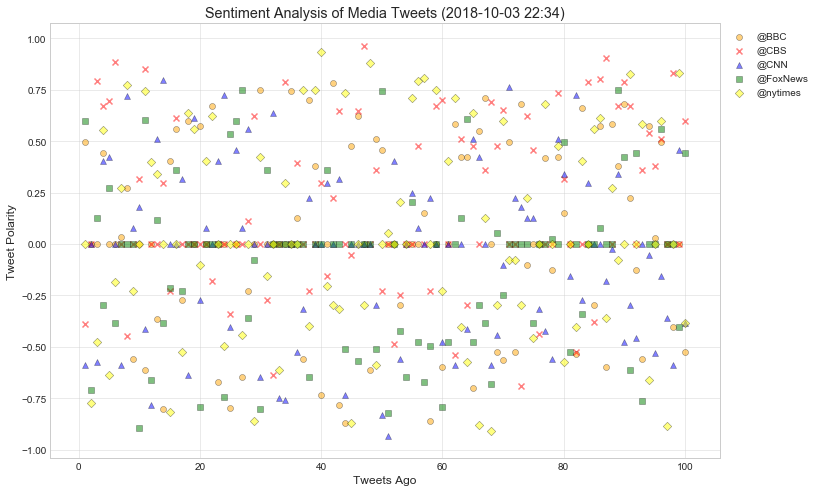

In [172]:
# Create scatter plot
style.use('seaborn-whitegrid')
markers = ['o','x','^','s','D']
colors = ['orange','red','blue','green','yellow']
plt.figure(figsize=(12,8))

i = 0
for user in users:
    plt.scatter(df[df['Twitter Handle'] == user]['Tweets Ago'],
                df[df['Twitter Handle'] == user]['Compound Score'],
                edgecolor='black',
                marker=markers[i],
                c=colors[i],
                alpha=0.5,
                label=user)

    i += 1

# # Incorporate the other graph properties
plt.legend(bbox_to_anchor=(1,1), fancybox=True, shadow=True)
now = datetime.now()
now = now.strftime("%Y-%m-%d %H:%M")
plt.title(f"Sentiment Analysis of Media Tweets ({now})")
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.grid(alpha=.5)
plt.savefig("Images/MediaSentimentScatter.png",bbox_inches="tight")

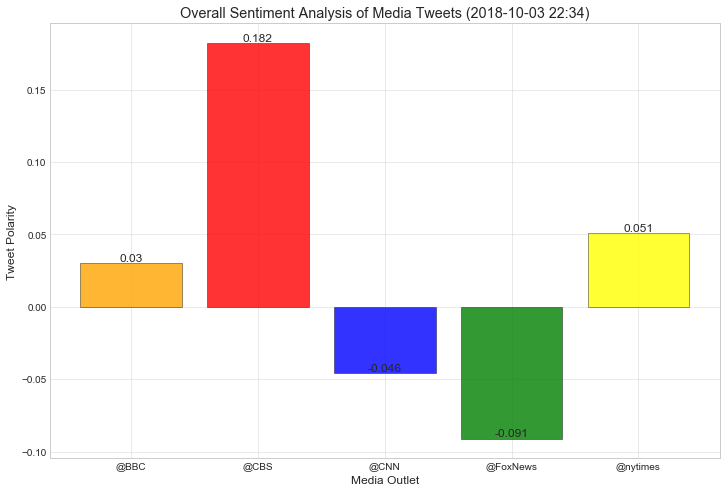

In [173]:
plt.figure(figsize=(12,8))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(x=rect.get_x() + rect.get_width()/2, 
                y=height,
                s=height,
                ha='center', 
                va='bottom',
                fontsize=12)

i = 0
for user in users:
    bar = plt.bar(users[i],
            ndf.iloc[i,0],
            edgecolor='black',
            color=colors[i],
            alpha=0.8)
    autolabel(bar)
    i += 1
    
plt.title(f"Overall Sentiment Analysis of Media Tweets ({now})")
plt.ylabel("Tweet Polarity")
plt.xlabel("Media Outlet")
plt.grid(alpha=.5)

# Save the Figure
plt.savefig("Images/MediaSentimentBar.png",bbox_inches="tight")
plt.show()

# OBSERVABLE TRENDS
1. At the time twitter data was pulled, @CBS had the most positive sentiment score overall
2. At the time twitter data was pulled, @FoxNews had the most negative sentiment score overall
3. There is a significant band of results where compound score = 0 and neutral score = 1.